In [1]:
# Import packages

from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdpas_opened
from funcs_mrcio import irdsec_opened
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as sfft
import time
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
import pyfftw
import multiprocessing

In [2]:
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = rescale_intensity(irdsec_opened(micrograph,0))
    
    # Use funcs_mrcio to extract header info
    header = irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

In [3]:
def rebin_helper(array, bin_size=2):
    """Take a two dimensional pixel array and average each bin_size x bin_size square to one pixel."""
    shape = (array.shape[0] // bin_size, bin_size,
             array.shape[1] // bin_size, bin_size)
    return array.reshape(shape).mean(-1).mean(1)

In [4]:
def rebin_mrc(filename, bin_size=2):
    """Take the filename of an .mrc file to be rebinned, perform the rebinning, and write out a new file."""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array
    image = irdsec_opened(micrograph,0)
    
    # Rebin the image
    rebinned_image = rebin_helper(image, bin_size)
    
    # Generate a new filename
    new_filename = "rebin_output/" + filename[0:-4] + "_bin_" + str(bin_size) + ".mrc"
    
    # Generate a new header
    nx, ny = rebinned_image.shape
    nxyz = np.array([nx, ny, 1], dtype=np.float32)
    dmin = np.min(rebinned_image)
    dmax = np.max(rebinned_image)
    dmean = np.sum(rebinned_image)/(nx*ny)
    
    # Open a new file
    rebinned_mrc = open(new_filename, 'wb')
    
    # Write the header to the new file
    iwrhdr_opened(rebinned_mrc, 
                  nxyz, 
                  dmin, 
                  dmax, 
                  dmean, 
                  mode=2)
    
    # Write the rebinned array to the new file
    iwrsec_opened(rebinned_image, rebinned_mrc)

In [5]:
def pad_image(image, header):
    """Take image and header from import_mrc() and pad image to make array square"""
    # Find the maximum dimension of the image
    max_dimension = np.maximum(header['nx'], header['ny'])
    
    # Make an array of the median pixel value of the image array with maximum dimensions
    padded_image = np.full(shape=(max_dimension, max_dimension),
                           fill_value=np.median(image))
    
    # Transplant image values into padded array
    padded_image[0:header['nx'],0:header['ny']] = image
    
    # Return padded image and header
    return padded_image, header

In [6]:
def scipy_fft(padded_image, print_timestamps=False):
    """Take padded image from pad_image() and return the FFT"""
    
    # Record the time it takes to do the FFT
    # for later comparison with multi-threaded FFTW
    
    # Start the timer
    start_time = time.time()
    
    # Perform the FFT
    padded_fft = sfft.rfft2(padded_image, norm="ortho")
    
    # Stop the timer
    end_time = time.time()
    
    if print_timestamps:
        # Print the elapsed time to the nearest hundreth of a millisecond
        print("scipy_fft(): FFT performed in", np.round((end_time-start_time)*1000, 2), "milliseconds.")
    
    # Return FFT of padded image
    return padded_fft

In [7]:
def west_fft(image, print_timestamps=False):
    """Take the padded image from pad_image() and return the FFT with the FFTW library"""
    
    image_dimensions = image.shape
    

In [8]:
def generate_diff_spectrum(padded_fft, sigma=1):
    """
    Apply gaussian filter to power spectrum of FFT from scipy_fft() or west_fft() 
    to generate a difference spectrum
    """
    
    # Generate the power spectrum of padded FFT
    padded_spectrum = np.abs(padded_fft)
    
    # Smooth the power spectrum with Gaussian filter
    smoothed_spectrum = gaussian(padded_spectrum, sigma)
    
    # Return the difference spectrum
    diff_spectrum = padded_spectrum - smoothed_spectrum
    
    return diff_spectrum, smoothed_spectrum

In [9]:
def find_diffraction_spots_quantile(diff_spectrum, quantile=0.99, x_window_percent = (0, 1), y_window_percent = (0, 1)):
    """
    Take a difference spectrum and find outliers greater than a given quantile,
    taking a user-defined window of the FFT.
    """
    
    # Define minimum and maximum indices of the window
    
    y_min = int(diff_spectrum.shape[0]*y_window_percent[0])
    y_max = int(diff_spectrum.shape[0]*y_window_percent[1])
    x_min = int(diff_spectrum.shape[1]*x_window_percent[0])
    x_max = int(diff_spectrum.shape[1]*x_window_percent[1])

    # Calculate the threshold on a subset of the spectrum
    quantile_threshold = np.quantile(diff_spectrum[y_min:y_max, x_min:x_max].flatten(), 
                                     quantile)
    
    # Find the indices of points where the value is greater than the threshold
    diffraction_spots = np.transpose(np.where(diff_spectrum >= quantile_threshold))
    
    # Discard the points that fall outside the window
    diffraction_spots_yfilt = np.logical_and(diffraction_spots[:,0] >= y_min, diffraction_spots[:,0] <= y_max)
    diffraction_spots_xfilt = np.logical_and(diffraction_spots[:,1] >= x_min, diffraction_spots[:,1] <= x_max)
    diffraction_spots_filt = np.array([diffraction_spots_yfilt, diffraction_spots_xfilt]).min(axis=0)
    
    # Subset the rows of diffraction_spots that fall within the window
    diffraction_spots = diffraction_spots[diffraction_spots_filt,:]

    return diffraction_spots

In [10]:
def find_diffraction_spots_sd(diff_spectrum, sd=3.0, x_window_percent = (0, 1), y_window_percent = (0, 1)):
    """
    Take a difference spectrum and find outliers past a certain number of SDs from the mean,
    taking a user-defined window of the FFT.
    """
    
    # Define minimum and maximum indices of the window
    
    y_min = int(diff_spectrum.shape[0]*y_window_percent[0])
    y_max = int(diff_spectrum.shape[0]*y_window_percent[1])
    x_min = int(diff_spectrum.shape[1]*x_window_percent[0])
    x_max = int(diff_spectrum.shape[1]*x_window_percent[1])

    # Calculate the mean on a subset of the spectrum
    mean = np.mean(diff_spectrum[y_min:y_max, x_min:x_max].flatten())
    # Calculate the standard deviation
    sd = np.std(diff_spectrum[y_min:y_max, x_min:x_max].flatten())
    
    # Find the indices of points where the value is greater than the threshold
    diffraction_spots = np.transpose(np.where(diff_spectrum >= mean+(3*sd)))
    
    # Discard the points that fall outside the window
    diffraction_spots_yfilt = np.logical_and(diffraction_spots[:,0] >= y_min, diffraction_spots[:,0] <= y_max)
    diffraction_spots_xfilt = np.logical_and(diffraction_spots[:,1] >= x_min, diffraction_spots[:,1] <= x_max)
    diffraction_spots_filt = np.array([diffraction_spots_yfilt, diffraction_spots_xfilt]).min(axis=0)
    
    # Subset the rows of diffraction_spots that fall within the window
    diffraction_spots = diffraction_spots[diffraction_spots_filt,:]

    return diffraction_spots

In [11]:
def replace_diffraction_spots(padded_fft, diffraction_spots, replace_distance_percent = 0.05):
    """
    Take FFT from scipy_fft() or west_fft() and replace diffraction spots according to indices from find_diffraction_spots.
    replace_distance_percent: fraction of x-dimension to move along the diagonal when finding new amplitude.
    """
    # Generate a masked fft
    masked_fft = np.copy(padded_fft)
    
    # Generate a vector of random phases with the same length as number of diffraction_spots
    phases = np.random.uniform(low = 0.0,
                               high = 2*np.pi,
                               size = diffraction_spots.shape[0])
    phase_count = 0
    
    # Figure out the movement distances horizontally and vertically
    replace_distance = int((np.min(padded_fft.shape)*replace_distance_percent)/np.sqrt(2))
    
    # Loop through axis-0, axis-1 coordinates
    for indices in diffraction_spots:
        # If we're in the top quadrant
        if indices[0] < int(padded_fft.shape[0]/2):
            # Construct the complex number by moving down and right
            real = np.real(masked_fft[indices[0]+replace_distance, indices[1]+replace_distance])
            imaginary = phases[phase_count]
            replacement = real + np.imag(imaginary)
            # Replace
            masked_fft[indices[0], indices[1]] = replacement
        # If we're in the bottom quadrant
        else:
            # Construct the complex number by moving up and right
            real = np.real(masked_fft[indices[0]-replace_distance, indices[1]+replace_distance])
            imaginary = phases[phase_count]
            replacement = real + np.imag(imaginary)
            # Replace
            masked_fft[indices[0], indices[1]] = replacement
        # Increment the phase count
        phase_count =+ 1
    
    return masked_fft

In [12]:
def scipy_inverse_fft(masked_fft, print_timestamps=False):
    """Take masked FFT from replace_diffraction_spots and return the padded image array"""
    
    # Record the time it takes to do the FFT
    # for later comparison with multi-threaded FFTW
    
    # Start the timer
    start_time = time.time()
    
    # Perform the FFT
    padded_masked_image = sfft.irfft2(masked_fft, norm="ortho")
    
    # Stop the timer
    end_time = time.time()
    
    if print_timestamps:
        # Print the elapsed time to the nearest hundreth of a millisecond
        print("scipy_ifft(): FFT performed in", np.round((end_time-start_time)*1000, 2), "milliseconds.")
    
    # Return FFT of padded image
    return padded_masked_image

In [13]:
def unpad_image(padded_masked_image, original_shape, header):
    """
    Take padded masked image from scipy_inverse_fft() or west_inverse_fft() 
    and original image shape and return unpadded image
    """
    return padded_masked_image[0:original_shape[0], 0:original_shape[1]]

In [14]:
def export_masked_mrc(masked_image, filename):
    """Take unpadded masked image from unpad_image() and write out a new header"""
    
    # Generate a new filename
    new_filename = "masked_output/" + filename[0:-4] + "_masked.mrc"
    
    # Generate a new header
    nx, ny = masked_image.shape
    nxyz = np.array([nx, ny, 1], dtype=np.float32)
    dmin = np.min(masked_image)
    dmax = np.max(masked_image)
    dmean = np.sum(masked_image)/(nx*ny)
    
    # Open a new file
    masked_mrc = open(new_filename, 'wb')
    
    # Write the header to the new file
    iwrhdr_opened(masked_mrc, 
                  nxyz, 
                  dmin, 
                  dmax, 
                  dmean, 
                  mode=2)
    
    # Write the rebinned array to the new file
    iwrsec_opened(masked_image, masked_mrc)
    
    print("Export complete!")

In [15]:
def mask_image(filename, 
               verbose=False, 
               sigma=1,
               quantile=0.99,
               sd=3.0,
               threshold_method,
               x_window_percent=(0, 1),
               y_window_percent=(0, 1),
               replace_distance_percent=0.05):
    """
    Take the filename of a micrograph in the .mrc format and subtract the streptavidin crystal lattice.
    print_timestamps: Boolean, whether to print how long it takes to perform the FFT and iFFT.
    sigma: Int. The SD of the Gaussian filter applied.
    quantile: Float. The quantile above which points will be designated diffraction spots to be masked.
    sd: Float. The number of SDs above the mean at which diffraction spots are detected.
    threshold_method: String. The thresholding method used to detect diffraction spots. Can be "quantile" or "sd".
    x_window_percent: Tuple. The upper and lower bounds of the x-dimension window in which to mask points (axis 1).
    x_window_percent: Tuple. The upper and lower bounds of the y-dimension window in which to mask points (axis 0).
    replace_distance_percent: Float. The fraction of the lesser dimension of the FFT to use as a radial distance to find replacement point values.
    """
    
    # Import the image
    image, header = import_mrc(filename)
    
    # Pad the image to make it square
    padded_image = pad_image(image, header)
    
    # Perform an FFT of the image
    padded_fft = scipy_fft(padded_image, verbose)
    
    # Subtract the FFT from a Gaussian-smoothed FFT
    diff_spectrum, smoothed_spectrum = generate_diff_spectrum(padded_fft, sigma)
    
    # Find diffraction spots
    if threshold_method == "quantile":
        diffraction_spots = find_diffraction_spots_quantile(diff_spectrum, quantile, x_window_percent, y_window_percent)
    if threshold_method == "sd":
        diffraction_spots = find_diffraction_spots_sd(diff_spectrum, sd, x_window_percent, y_window_percent)
    else:
        print("No thresholding method specificed. Please specify a method using the threshold_method parameter.")
        return

    if verbose:
        print("Number of diffraction spots:" + diffraction_spots.shape)
    
    # Replace the diffraction spots
    masked_fft = replace_diffraction_spots(padded_fft, diffraction_spots, replace_distance_percent)
    
    # Perform the inverse FFT
    padded_masked_image = scipy_inverse_fft(masked_fft, print_timestamps)
    
    # Extract the original image from the padded inverse FFT
    masked_image = unpad_image(padded_masked_image, image.shape)
    
    # Export the image as an .mrc file
    export_masked_mrc(masked_image, filename)
    
    if verbose:
        print(filename + " masked successfully!")

SyntaxError: non-default argument follows default argument (3859961947.py, line 6)

In [16]:
filename = "test_image_bin_2.mrc"

In [17]:
image, header = import_mrc(filename)

In [18]:
padded_image, header = pad_image(image, header)

In [37]:
padded_image.dtype

dtype('float32')

In [38]:
image_empty = pyfftw.empty_aligned(padded_image.shape, dtype='float32')

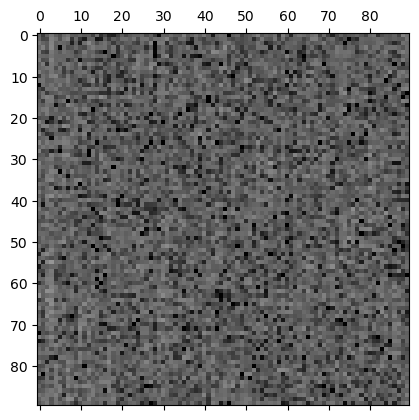

In [84]:
plt.matshow(np.log10((np.abs(fft))[10:100,10:100]),
           cmap = "Greys_r",
           vmax = 3,
           vmin = 0)

In [47]:
padded_fft = scipy_fft(padded_image, True)

scipy_fft(): FFT performed in 145.38 milliseconds.


In [35]:
padded_fft.shape

(5760, 2881)

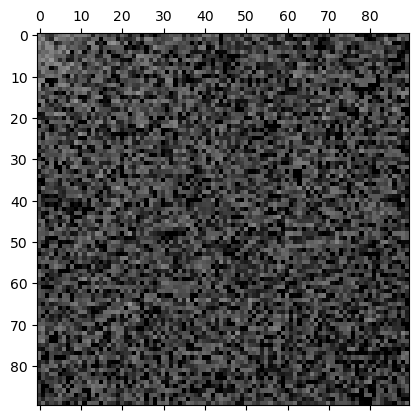

In [80]:
plt.matshow(np.log10(np.abs(padded_fft))[10:100, 10:100],
           cmap = "Greys_r",
           vmax = 1,
           vmin = -1)

In [ ]:
diff_spectrum, smoothed_spectrum = generate_diff_spectrum(padded_fft, 9)

In [ ]:
plt.matshow(np.log10(np.abs(smoothed_spectrum))[10:1000, 10:1000],
           cmap = "Greys_r",
           vmax = 1,
           vmin = -1)

In [ ]:
plt.matshow(np.log10(np.abs(diff_spectrum))[10:1000, 10:1000],
           cmap = "Greys_r",
           vmax = 1,
           vmin = -1)

In [ ]:
# Look at a histogram of diff_spectrum values

plt.hist(np.abs(diff_spectrum)[100:200, 100:200].flatten(),bins = 50)
plt.show()

In [ ]:
diffraction_spots = find_diffraction_spots(diff_spectrum, 0.99, (0, 0.7), (0, 1))

In [ ]:
masked_fft = replace_diffraction_spots(padded_fft, diffraction_spots, 0.1)

In [ ]:
plt.matshow(np.log10(np.abs(masked_fft))[10:1000, 10:1000],
           cmap = "Greys_r",
           vmax = 1,
           vmin = -1)

In [ ]:
padded_masked_image = scipy_inverse_fft(masked_fft, True)

In [ ]:
plt.matshow(padded_masked_image)

In [ ]:
masked_image = unpad_image(padded_masked_image, image.shape)

In [ ]:
plt.matshow(rescale_intensity(masked_image, in_range=(-1, 1)))

In [ ]:
export_masked_mrc(masked_image, filename)

In [ ]:
mask_image(filename, 
        print_timestamps=True, 
               sigma=9,
               quantile=0.99,
               x_window_percent=(0.1, 0.7),
               y_window_percent=(0.1, 1),
               replace_distance_percent=0.05)

In [ ]:
# Ground truth: we know that 10, 105 is a diffraction spot. Let's make sure we can see it.

padded_spectrum = np.abs(padded_fft)
print(padded_spectrum[10, 105])
plt.matshow(padded_spectrum[5:15, 100:110],
           cmap = "Greys_r")